# Day_087

### 練習時間
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x)
            x = BatchNormalization()(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
def plt_model_result(result):
    num_colors = len(result.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1. * i/num_colors) for i in range(num_colors)]
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-loss'])), result[cond]['train-loss'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-loss'])), result[cond]['valid-loss'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Loss")
    plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(12, 10))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(result[cond]['train-acc'])), result[cond]['train-acc'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-acc'])), result[cond]['valid-acc'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### 改變 reduce_lr 的 patience 和 factor

In [8]:
Factors = [0.4, 0.8]
Waittimes = [10, 25]
results = {}
for factor, waittime in itertools.product(Factors, Waittimes):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f'factor : {factor}, patience :{waittime}')
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    reduce_lr = ReduceLROnPlateau(factor = factor, min_lr = 1e-12, monitor = 'val_loss', patience = waittime, verbose = 1)
    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True,
              callbacks = [reduce_lr]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'factor : {factor}, patience :{waittime}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

factor : 0.4, patience :10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)         

Epoch 48/50
50000/50000 [==============================] - 27s 535us/step - loss: 0.7063 - acc: 0.7824 - val_loss: 1.5144 - val_acc: 0.5020
Epoch 49/50
50000/50000 [==============================] - 27s 538us/step - loss: 0.7039 - acc: 0.7827 - val_loss: 1.5135 - val_acc: 0.5003
Epoch 50/50
50000/50000 [==============================] - 27s 534us/step - loss: 0.7007 - acc: 0.7846 - val_loss: 1.5130 - val_acc: 0.5004

Epoch 00050: ReduceLROnPlateau reducing learning rate to 6.40000042039901e-05.
factor : 0.4, patience :25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
___________

50000/50000 [==============================] - 26s 527us/step - loss: 0.5783 - acc: 0.8303 - val_loss: 1.6013 - val_acc: 0.4960
Epoch 46/50
50000/50000 [==============================] - 27s 533us/step - loss: 0.5611 - acc: 0.8349 - val_loss: 1.6331 - val_acc: 0.4925

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 47/50
50000/50000 [==============================] - 27s 543us/step - loss: 0.5350 - acc: 0.8456 - val_loss: 1.6137 - val_acc: 0.4933
Epoch 48/50
50000/50000 [==============================] - 26s 518us/step - loss: 0.5137 - acc: 0.8581 - val_loss: 1.6138 - val_acc: 0.4947
Epoch 49/50
50000/50000 [==============================] - 27s 533us/step - loss: 0.5033 - acc: 0.8615 - val_loss: 1.6230 - val_acc: 0.4915
Epoch 50/50
50000/50000 [==============================] - 27s 540us/step - loss: 0.4964 - acc: 0.8649 - val_loss: 1.6249 - val_acc: 0.4955
factor : 0.8, patience :10
________________________________________________________________

50000/50000 [==============================] - 27s 537us/step - loss: 0.6635 - acc: 0.7966 - val_loss: 1.5386 - val_acc: 0.4940
Epoch 42/50
50000/50000 [==============================] - 27s 540us/step - loss: 0.6520 - acc: 0.8017 - val_loss: 1.5395 - val_acc: 0.4959
Epoch 43/50
50000/50000 [==============================] - 27s 533us/step - loss: 0.6390 - acc: 0.8069 - val_loss: 1.5476 - val_acc: 0.4936
Epoch 44/50
50000/50000 [==============================] - 27s 536us/step - loss: 0.6267 - acc: 0.8095 - val_loss: 1.5677 - val_acc: 0.4940
Epoch 45/50
50000/50000 [==============================] - 26s 525us/step - loss: 0.6147 - acc: 0.8156 - val_loss: 1.5640 - val_acc: 0.4921
Epoch 46/50
50000/50000 [==============================] - 27s 540us/step - loss: 0.6024 - acc: 0.8211 - val_loss: 1.5667 - val_acc: 0.4972
Epoch 47/50
50000/50000 [==============================] - 27s 534us/step - loss: 0.5898 - acc: 0.8249 - val_loss: 1.5849 - val_acc: 0.4994
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 27s 540us/step - loss: 0.7220 - acc: 0.7712 - val_loss: 1.5085 - val_acc: 0.4988
Epoch 39/50
50000/50000 [==============================] - 27s 532us/step - loss: 0.7057 - acc: 0.7786 - val_loss: 1.5428 - val_acc: 0.4856
Epoch 40/50
50000/50000 [==============================] - 24s 482us/step - loss: 0.6882 - acc: 0.7831 - val_loss: 1.5226 - val_acc: 0.4980
Epoch 41/50
50000/50000 [==============================] - 28s 556us/step - loss: 0.6701 - acc: 0.7921 - val_loss: 1.5104 - val_acc: 0.5053
Epoch 42/50
50000/50000 [==============================] - 27s 536us/step - loss: 0.6505 - acc: 0.8002 - val_loss: 1.5329 - val_acc: 0.5004
Epoch 43/50
50000/50000 [==============================] - 26s 528us/step - loss: 0.6325 - acc: 0.8079 - val_loss: 1.5259 - val_acc: 0.4999
Epoch 44/50
50000/50000 [==============================] - 27s 534us/step - loss: 0.6165 - acc: 0.8128 - val_loss: 1.5719 - val_acc: 0.4931
Epoch 45/50
50000/50000 [=======

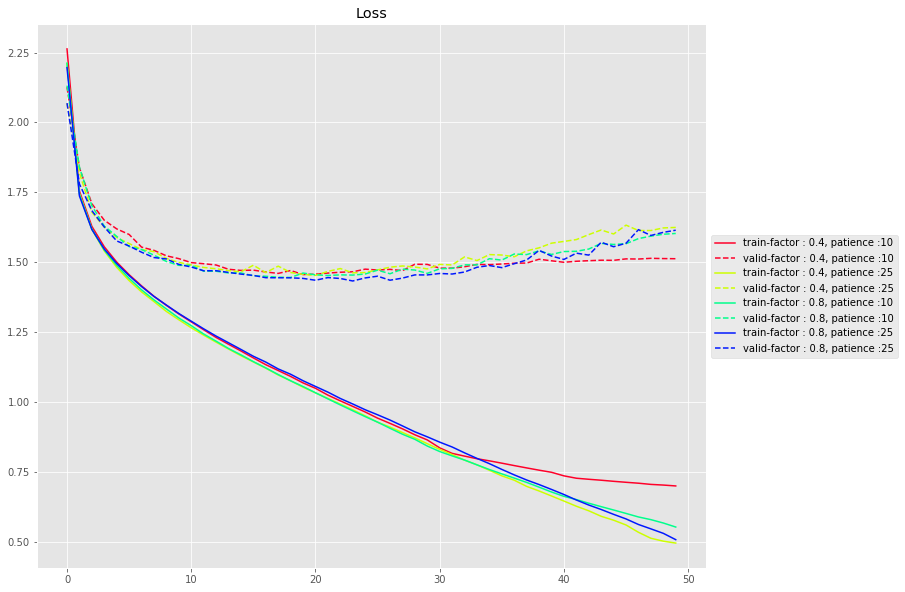

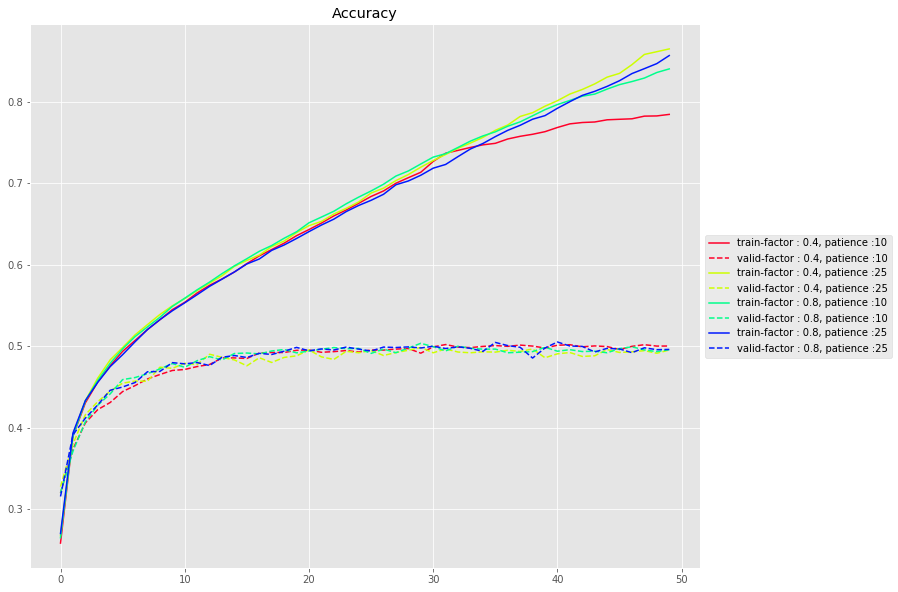

In [9]:
 plt_model_result(results)

### 將 optimizer 換成 Adam、RMSprop

In [10]:
Adam = optimizers.Adam(lr = LEARNING_RATE)
RMSprop = optimizers.RMSprop(lr = LEARNING_RATE, rho = 0.9, epsilon = None, decay = 0.0)

In [11]:
results = {}
for optimizer in ['Adam', 'RMSprop']:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f'Optimizer:{optimizer}')
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()   
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    reduce_lr = ReduceLROnPlateau(factor = 0.5, min_lr = 1e-12, monitor = 'val_loss', patience = 5, verbose = 1)
    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True,
              callbacks = [reduce_lr]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f'Optimizer:{optimizer}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Optimizer:Adam
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512   

50000/50000 [==============================] - 25s 507us/step - loss: 0.2705 - acc: 0.9425 - val_loss: 1.6690 - val_acc: 0.5272
Epoch 46/50
50000/50000 [==============================] - 28s 561us/step - loss: 0.2707 - acc: 0.9424 - val_loss: 1.6712 - val_acc: 0.5263
Epoch 47/50
50000/50000 [==============================] - 28s 558us/step - loss: 0.2692 - acc: 0.9429 - val_loss: 1.6702 - val_acc: 0.5275
Epoch 48/50
50000/50000 [==============================] - 27s 545us/step - loss: 0.2686 - acc: 0.9428 - val_loss: 1.6752 - val_acc: 0.5254

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 49/50
50000/50000 [==============================] - 28s 553us/step - loss: 0.2673 - acc: 0.9437 - val_loss: 1.6744 - val_acc: 0.5264
Epoch 50/50
50000/50000 [==============================] - 28s 560us/step - loss: 0.2660 - acc: 0.9435 - val_loss: 1.6757 - val_acc: 0.5275
Optimizer:RMSprop
_________________________________________________________________
Layer (

50000/50000 [==============================] - 27s 548us/step - loss: 0.2644 - acc: 0.9377 - val_loss: 1.7772 - val_acc: 0.5257
Epoch 41/50
50000/50000 [==============================] - 27s 540us/step - loss: 0.2605 - acc: 0.9393 - val_loss: 1.7905 - val_acc: 0.5243
Epoch 42/50
50000/50000 [==============================] - 27s 549us/step - loss: 0.2581 - acc: 0.9399 - val_loss: 1.7991 - val_acc: 0.5237

Epoch 00042: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 43/50
50000/50000 [==============================] - 28s 550us/step - loss: 0.2475 - acc: 0.9441 - val_loss: 1.7919 - val_acc: 0.5243
Epoch 44/50
50000/50000 [==============================] - 27s 549us/step - loss: 0.2454 - acc: 0.9452 - val_loss: 1.7995 - val_acc: 0.5284
Epoch 45/50
50000/50000 [==============================] - 27s 545us/step - loss: 0.2435 - acc: 0.9463 - val_loss: 1.8002 - val_acc: 0.5274
Epoch 46/50
50000/50000 [==============================] - 27s 537us/step - loss: 0.2410 - 

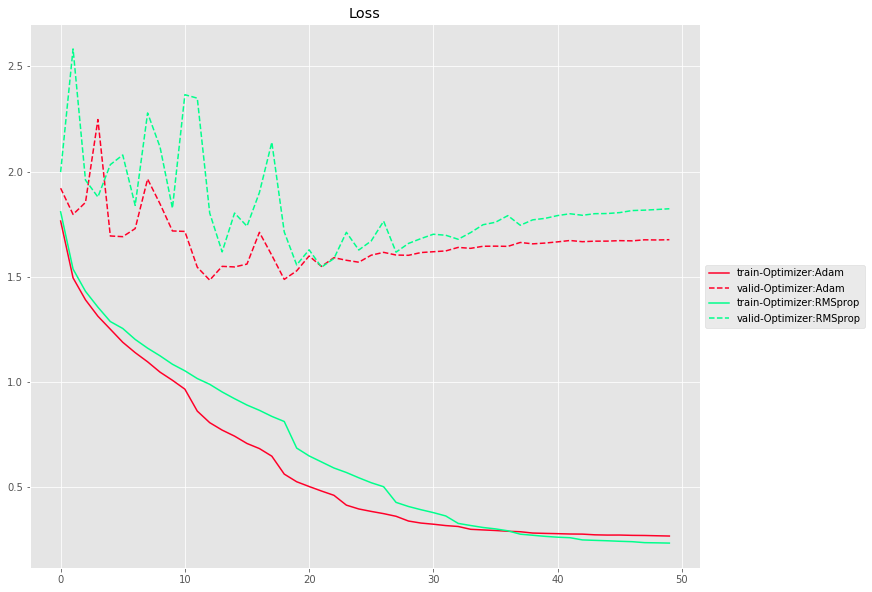

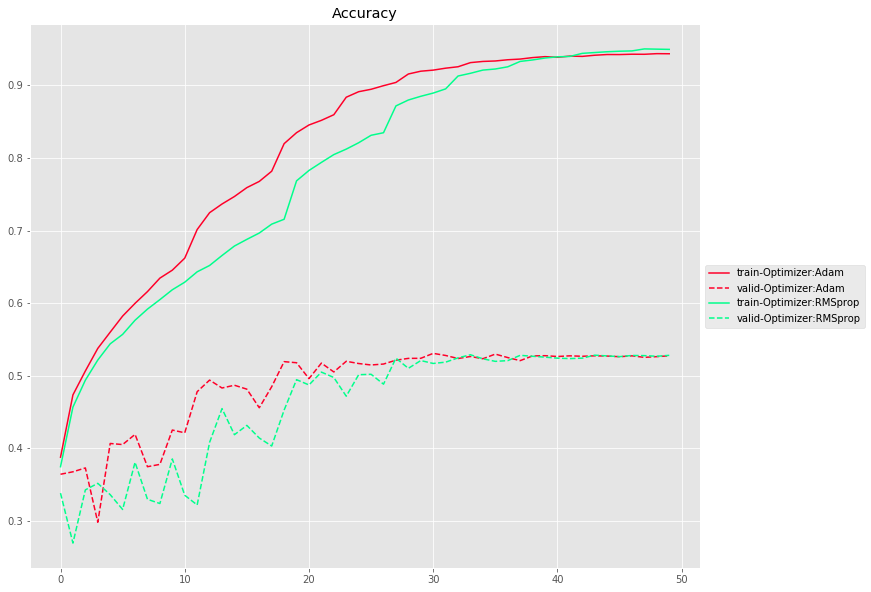

In [12]:
 plt_model_result(results)